In [2]:
# Import necessary modules
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import argparse
import os
import cv2

In [3]:
# Load the images directories
path = "/home/geeran/Documents/brain/dataset"
print(os.listdir(path))
image_paths = list(paths.list_images(path))
print(len(image_paths))

['yes', 'no']
3000


In [4]:
images = []
labels = []
for image_path in image_paths:
    label = image_path.split(os.path.sep)[-2]
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224, 224))
    images.append(image)
    labels.append(label)

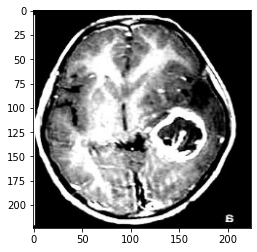

In [5]:
# Plot an image
def plot_image(image):
    plt.imshow(image)
plot_image(images[0])

In [6]:
# Convert into numpy arrays
images = np.array(images) / 255.0
labels = np.array(labels)

In [7]:
# Perform One-hot encoding
label_binarizer = LabelBinarizer()
labels = label_binarizer.fit_transform(labels)
labels = to_categorical(labels)
print(labels[0])

[0. 1.]


In [1]:
#Split the dataset
(train_X, test_X, train_Y, test_Y) = train_test_split(images, labels, 
                                                      test_size= 0.10,
                                                      random_state= 42, 
                                                      stratify= labels)

NameError: name 'train_test_split' is not defined

In [ ]:
# Build the Image Data Generator
train_generator = ImageDataGenerator(fill_mode= 'nearest', rotation_range= 15)

In [ ]:
# Build the model
base_model = VGG16(weights= 'imagenet',

input_tensor= Input(shape = (224, 224, 3)),
include_top= False)

base_input = base_model.input
base_output = base_model.output
base_output = AveragePooling2D(pool_size=(4, 4))(base_output)
base_output = Flatten(name="flatten")(base_output)
base_output = Dense(64, activation="relu")(base_output)
base_output = Dropout(0.5)(base_output)
base_output = Dense(2, activation="softmax")(base_output)

In [ ]:
# Freeze the layers
for layer in base_model.layers:
layer.trainable = False

In [ ]:
# Compile the model
model = Model(inputs = base_input, outputs = base_output)
model.compile(optimizer= Adam(learning_rate= 1e-3),

metrics= ['accuracy'], loss= 'binary_crossentropy')

In [ ]:
# Let's see the architecture summary of our model
model.summary()

In [ ]:
batch_size = 8
train_steps = len(train_X) // batch_size
validation_steps = len(test_X) // batch_size
epochs = 10

In [ ]:
# Fit the model
history = model.fit_generator(train_generator.flow(train_X, train_Y, batch_size = batch_size),
                              steps_per_epoch= train_steps, validation_data = (test_X, test_Y),
                              validation_steps= validation_steps, epochs= epochs)

In [ ]:
# Evaluate the model
predictions = model.predict(test_X, batch_size= batch_size)
predictions = np.argmax(predictions, axis= 1)
actuals = np.argmax(test_Y, axis= 1)

In [ ]:
# Print Classification report and Confusion matrix
print(classification_report(actuals, predictions,target_names= label_binarizer.classes_))

cm = confusion_matrix(actuals, predictions)
print(cm)

In [ ]:
# Final accuracy of our model
total = sum(sum(cm))
accuracy = (cm[0, 0] + cm[1, 1]) / total
print("Accuracy: {:.4f}".format(accuracy))

In [ ]:
# Plot the losses and accuracies
N = epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"],

label= "train_loss")

plt.plot(np.arange(0, N), history.history["val_loss"],

label= "val_loss")

plt.plot(np.arange(0, N), history.history["accuracy"],

label= "train_acc")

plt.plot(np.arange(0, N), history.history["val_accuracy"],

label= "val_acc")

plt.title("Training Loss and Accuracy on Brain Dataset")
plt.xlabel("Epoch")
plt.ylabel("Loss / Accuracy")
plt.legend(loc= "lower left")
plt.savefig("plot.jpg")